<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Modeling Plan


- Model for Overall players
- Model for Foward position players
- Model for Midfielder postion players
- Model for Defense position plauyers
- Model for Goal Keepers

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>


In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
import bamboolib as bam

import unicodedata
import re
import json

import acquire

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression 

#statistical tests
from scipy import stats
from scipy.stats import pearsonr, spearmanr

from math import sqrt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup
import prepare
import plotly.express as px

#imports to show interactive visuals on github
import plotly.io as pio
pio.renderers

import modeling
#import model
import math
from math import sqrt


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Acquire` Data.

In [2]:
df = acquire.get_fifa_data()
print("Row and column count:",df.shape)

Row and column count: (142079, 111)


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Import [Prepare.py](https://github.com/Jules-Ray-Kayla-Bert-Capstone-FiFA/fifa/blob/main/prepare.py) File.
`Summary:`
    This file was created with the purpose of cleaning, encoding, scaling, dropping, and adding collumns to our existing data. It is necessary to complete this preperation step before we start exploring and modeling our data.

In [3]:
#defining df as our imported prepped data.
df = prepare.prepped_data(df)

Before dropping nulls, 142079 rows, 111 cols
After dropping nulls. 131489 rows. 66 cols
After cleaning the data and adding additional columns there are: 98804 rows. 83 cols


## Removing outliers

In [4]:
cols = ['overall','potential'] 
def handle_outliers(df, cols, k):
    """this will eliminate most outliers, use a 1.5 k value if unsure because it is the most common, make sure to define cols value as the features
    you want the outliers to be handled. this should be done before running the function and outiside of it"""

    
    # Create placeholder dictionary for each columns bounds
    bounds_dict = {}
   
    for col in cols:
        # get necessary iqr values
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound =  q3 + k * iqr
        lower_bound =  q1 - k * iqr

        #store values in a dictionary referencable by the column name
        #and specific bound
        bounds_dict[col] = {}
        bounds_dict[col]['upper_bound'] = upper_bound
        bounds_dict[col]['lower_bound'] = lower_bound

    for col in cols:
        #retrieve bounds
        col_upper_bound = bounds_dict[col]['upper_bound']
        col_lower_bound = bounds_dict[col]['lower_bound']

        #remove rows with an outlier in that column
    df = df[(df[col] < col_upper_bound) & (df[col] > col_lower_bound)]
        
    return df

df = handle_outliers(df,cols,1.5)

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Splitting Data for Modeling

In [5]:
train, validate, test = prepare.split(df)

Train: 58213 rows, 83 cols
Validate: 26055 rows, 83 cols
Test: 13946 rows, 83 cols


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Overall Players

## Plan
- Use key features to create a good predictive model
- Use a minimum of 3 models
- Pick the best performing model
- Run model on test data

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Relationship to Wage_eur Plot

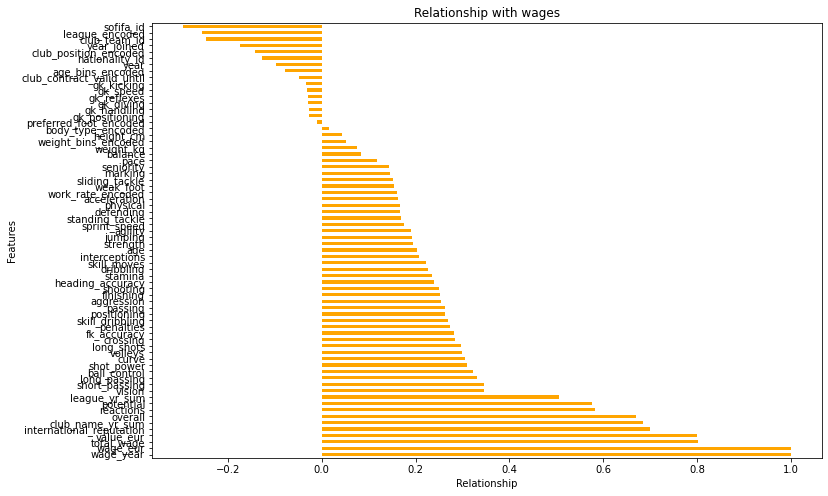

In [6]:
plt.figure(figsize = (12,8))
train.corr()['wage_eur'].sort_values(ascending=False).plot(kind='barh', color='orange')
plt.title('Relationship with wages')
plt.xlabel('Relationship')
plt.ylabel('Features')
plt.show()

In [7]:
features_cor =  train.corr()['wage_eur'].sort_values(ascending=False)
features_cor = pd.DataFrame(features_cor)
features_cor.head(15)

                          wage_eur
wage_year                 1.000000
wage_eur                  1.000000
total_wage                0.801017
value_eur                 0.799072
international_reputation  0.699798
club_name_yr_sum          0.683929
overall                   0.670422
reactions                 0.582250
potential                 0.576212
league_yr_sum             0.506001
vision                    0.346656
short_passing             0.345914
long_passing              0.330425
ball_control              0.321539
shot_power                0.309107

`Takeaways:` 
For this Exploration section I wil be focusing on the skills that are under or equal to 70 percent of correlation and greater then 48 percent. 
The list below will be the skills and stats that I will be focusing on.

- international_reputation
- overall
- passing
- ball_control
- short_passing
- reactions
- potential
- dribbling
- vision
- skill_dribbling
- league_yr_sum
- long_passing
- shooting



In [8]:
# identifying mvp columns
mvp = ['international_reputation','overall','reactions','potential']

In [9]:
X_train = train[mvp]
y_train = train[['wage_eur']]

X_validate = validate[mvp]
y_validate = validate[['wage_eur']]

X_test = test[mvp]
y_test = test[['wage_eur']]

In [10]:
modeling.create_baseline(y_train, y_validate,' wage_eur')

RMSE using Mean
Train/In-Sample:  23481.13 
Validate/Out-of-Sample:  19935.79
RMSE using Median
Train/In-Sample:  25168.55 
Validate/Out-of-Sample:  20296.97


In [11]:
#.   Use this!!!!
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)# 1. Predict wage_eur_pred_mean
wage_eur_pred_mean = y_train['wage_eur'].mean()
y_train['wage_eur_pred_mean'] = wage_eur_pred_mean
y_validate['wage_eur_pred_mean'] = wage_eur_pred_mean# 2. compute wage_eur_pred_median
wage_eur_pred_median = y_train['wage_eur'].median()
y_train['wage_eur_pred_median'] = wage_eur_pred_median
y_validate['wage_eur_pred_median'] = wage_eur_pred_median# 3. RMSE of wage_eur_pred_mean
rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))# 4. RMSE of wage_eur_pred_median
rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_median)**(1/2)
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  23481.13 
Validate/Out-of-Sample:  19935.79
RMSE using Median
Train/In-Sample:  25168.55 
Validate/Out-of-Sample:  20296.97


# RMSE

In [12]:
model = LinearRegression().fit(X_train, y_train.wage_eur)
predictions = model.predict(X_train)

In [13]:
modeling.linear_model(y_train,y_validate, X_train,X_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  14387.186139593161 
Validation/Out-of-Sample:  13794.31310783574


In [14]:
## create the model object
#lm = LinearRegression(normalize=True)
## fit the model to our training data. We must specify the column in y_train, 
## since we have converted it to a dataframe from a series! 
#lm.fit(X_train, y_train.wage_eur)
## predict train
#y_train['wage_eur_pred_lm'] = lm.predict(X_train)
## evaluate: rmse
#rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_lm)**(1/2)
## predict validate
#y_validate['wage_eur_pred_lm'] = lm.predict(X_validate)
## evaluate: rmse
#rmse_validate_lm = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_lm)**(1/2)
#print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
#      "\nValidation/Out-of-Sample: ", rmse_validate_lm)

In [15]:
modeling.lassolars_model(y_train,y_validate,X_train,X_validate)

RMSE for Lasso + Lars
Training/In-Sample:  14390.288284191163 
Validation/Out-of-Sample:  13748.439932780246


In [16]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_lars)**(1/2)

# predict validate
y_validate['wage_eur_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lars)


RMSE for Lasso + Lars
Training/In-Sample:  14390.288284191163 
Validation/Out-of-Sample:  13748.439932780246


In [17]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_glm)**(1/2)

# predict validate
y_validate['wage_eur_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  25168.553127153584 
Validation/Out-of-Sample:  11953.927056606866


In [18]:
#residuals
y_train['lm_residuals'] = y_train['wage_eur_pred_lm'] - y_train['wage_eur']
y_validate['lm_residuals'] = y_validate['wage_eur_pred_lm'] - y_validate['wage_eur']
#residuals
y_train['lars_residuals'] = y_train['wage_eur_pred_lars'] - y_train['wage_eur']
y_validate['lars_residuals'] = y_validate['wage_eur_pred_lars'] - y_validate['wage_eur']
#residuals
y_train['glm_residuals'] = y_train['wage_eur_pred_glm'] - y_train['wage_eur']
y_validate['glm_residuals'] = y_validate['wage_eur_pred_glm'] - y_validate['wage_eur']

In [19]:
y_test = pd.DataFrame(y_test)
y_test

       wage_eur
4      115000.0
5      130000.0
6      160000.0
7      155000.0
9      100000.0
...         ...
98696     500.0
98697     500.0
98698     500.0
98699     500.0
98700     500.0

[13946 rows x 1 columns]

***
# Evaluating Models

In [20]:
from sklearn.linear_model import LinearRegression
y = pd.DataFrame(y_train.wage_eur)
X = pd.DataFrame(X_train)
# assuming X and y are already defined
m = LinearRegression().fit(X, y)
train['yhat'] = m.predict(X)

In [21]:

df = pd.DataFrame(train[['international_reputation','overall','reactions',
                         'potential','wage_eur','yhat']])
df.head()

     international_reputation  overall  reactions  potential  wage_eur  \
212                         4       87         83         87  190000.0   
213                         4       85         85         87  200000.0   
214                         3       84         78         85  180000.0   
215                         3       83         83         85  150000.0   
216                         3       82         78         82  130000.0   

              yhat  
212  118024.989587  
213  116579.889522  
214   87558.428414  
215   87344.226804  
216   84262.902411  

In [22]:
#creating a baseline from the mean of the target variable
baseline = y.mean()
df['baseline'] = y.wage_eur.mean()
# turning baseline to int from float
df.baseline = df.baseline.astype(int)
# residual = actual - predicted
df['residual'] = df.wage_eur - df.yhat
df['baseline_residual'] = df.wage_eur - df.baseline

## Baseline = 14060.50

In [23]:
df['residual^2'] = df.residual**2
df['baseline_residual^2'] = df.baseline_residual**2

In [24]:
actual = y_train.wage_eur
predicted = df.yhat
residuals = actual - predicted
df['residual^2'] = df.residual**2
df['baseline_residual^2'] = df.baseline_residual**2

In [25]:
def residuals(actual, predicted):
    return actual - predicted

#sum of squared errors (SSE)
def sse(actual, predicted):
    return (residuals(actual, predicted) **2).sum()

#explained sum of squares (ESS)
def ess(actual, predicted):
    return ((predicted - actual.mean()) ** 2).sum()

#total sum of squares (TSS)
def tss(actual):
    return ((actual - actual.mean()) ** 2).sum()

#mean squared error (MSE)
def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

#root mean squared error (RMSE)
def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

# returns r2 scor
def r2_score(actual, predicted):
    return ess(actual, predicted) / tss(actual)

def regression_errors(actual, predicted):
    return pd.Series({
                        'SSE': sse(actual, predicted),
                        'ESS': ess(actual, predicted),
                        'TSS': tss(actual),
                        'MSE': mse(actual, predicted),
                        'RMSE': rmse(actual, predicted),
                        })

def baseline_mean_errors(actual):
    predicted = actual.mean()
    return {
             'SSE': sse(actual, predicted),
             'MSE': mse(actual, predicted),
             'RMSE': rmse(actual, predicted),
            }

def better_than_baseline(actual, predicted):
    rmse_baseline = rmse(actual, actual.mean())
    rmse_model = rmse(actual, predicted)
    return rmse_model < rmse_baseline

In [26]:
regression_errors(actual, predicted)

SSE     1.204957e+13
ESS     2.004694e+13
TSS     3.209652e+13
MSE     2.069911e+08
RMSE    1.438719e+04
dtype: float64

In [27]:
baseline_mean_errors(actual)

{'SSE': 32096515912133.035,
 'MSE': 551363370.933177,
 'RMSE': 23481.127974038576}

In [28]:
# calculate R2 the easy way:
from sklearn.metrics import r2_score
r2_score(df.wage_eur, df.yhat)

0.624583104487026

In [29]:
import statsmodels.api as sm
X2 = sm.add_constant(df.potential)
est = sm.OLS(df.wage_eur, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               wage_eur   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                 2.893e+04
Date:                Thu, 11 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:18:51   Log-Likelihood:            -6.5671e+05
No. Observations:               58213   AIC:                         1.313e+06
Df Residuals:                   58211   BIC:                         1.313e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.338e+05    872.597   -153.278      0.0

In [30]:
# actual = y_train.wage_eur
# predicted = df.yhat
# residuals = actual - predicted

In [31]:
y_train

       wage_eur  wage_eur_pred_mean  wage_eur_pred_median  wage_eur_pred_lm  \
212    190000.0         14060.50195                5000.0     118024.989587   
213    200000.0         14060.50195                5000.0     116579.889522   
214    180000.0         14060.50195                5000.0      87558.428414   
215    150000.0         14060.50195                5000.0      87344.226804   
216    130000.0         14060.50195                5000.0      84262.902411   
...         ...                 ...                   ...               ...   
98746     500.0         14060.50195                5000.0      -1310.684160   
98747     500.0         14060.50195                5000.0      -7409.953927   
98748     500.0         14060.50195                5000.0      -3224.489115   
98749     500.0         14060.50195                5000.0      -4455.387571   
98750     500.0         14060.50195                5000.0      -4137.505272   

       wage_eur_pred_lars  wage_eur_pred_glm  lm_re

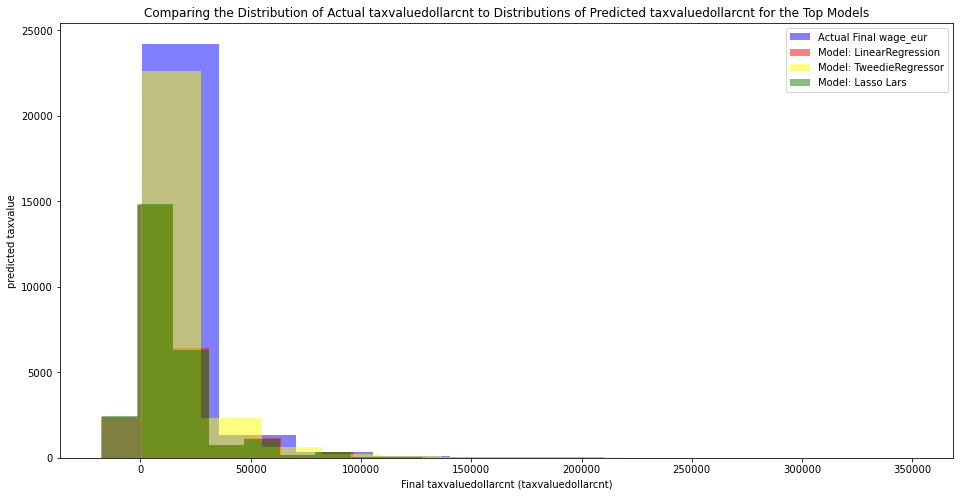

In [32]:
def actual_vs_predicted():
    # plot to visualize actual vs predicted. 
    plt.figure(figsize=(16,8))
    plt.hist(y_validate.wage_eur, color='blue', alpha=.5, label="Actual Final wage_eur")
    plt.hist(y_validate.wage_eur_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
    plt.hist(y_validate.wage_eur_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
    plt.hist(y_validate.wage_eur_pred_lars, color='green', alpha=.5, label="Model: Lasso Lars")
    plt.xlabel("Final taxvaluedollarcnt (taxvaluedollarcnt)")
    plt.ylabel("predicted taxvalue")
    plt.title("Comparing the Distribution of Actual taxvaluedollarcnt to Distributions of Predicted taxvaluedollarcnt for the Top Models")
    plt.legend()
    plt.show()
actual_vs_predicted()

In [33]:
# sklearn.metrics.explained_variance_score
from sklearn.metrics import explained_variance_score
evs = explained_variance_score(df.wage_eur, df.yhat)
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.625


In [34]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
        'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_mean)}])
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate_lm,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_lm)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'Lasso alpha 1', 
    'RMSE_validate': rmse_validate_lars,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_lars)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'GLM (tweedie)', 
    'RMSE_validate': rmse_validate_glm,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_glm)}, ignore_index=True)
metric_df 

NameError: name 'rmse_validate_lm' is not defined

In [ ]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['wage_eur_pred_LINEAR'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test_lm = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_LINEAR)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test_lm)

y_test = pd.DataFrame(y_test)

# predict on test
y_test['wage_eur_pred_LASSO'] = lars.predict(X_test_scaled)

# evaluate: rmse
rmse_test_lars = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_LASSO)**(1/2)

print("RMSE for OLS Model using Lasso\nOut-of-Sample Performance: ", rmse_test_lars)

y_test = pd.DataFrame(y_test)

#predict on test
y_test['pred_Poly'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.wage_eur, y_test.pred_Poly)**(0.5)

print(f"""
RMSE for Polynomial Regressor, degrees=2:
Test/Out-of-Sample Performance: {rmse_test}
""")



#predict on test
y_test['wage_eur_pred_glm'] = glm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_glm)**(1/2)
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)


In [ ]:
y_test

In [ ]:
sns.scatterplot(data = y_test)